In [11]:
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn import metrics
import NegotiationTools as negotools
nt = negotools.NegTools()
stat = negotools.StatisticsLogger()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (311) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [130]:
data = pd.read_csv('./aggregations_brats2019v2/aggregation_results.csv', index_col=0)
data = data.loc[data.conflict_area > 0]
categories = ['very small', 'small', 'medium', 'large', 'very large']
data['conflict_area_scale'], consensus_bins = pd.qcut(data['conflict_area'], len(categories), labels = categories, retbins=True)
for votes_col in ['votes_Negative_vs_Positive_1vs3', 'votes_Negative_vs_Positive_2vs2', 'votes_Negative_vs_Positive_3vs1']:
        data[f"{votes_col}_norm"] =  data[votes_col]/data['conflict_area']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (311) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
for c in data.columns.to_list():
    print(c)

full_FN
full_FP
full_Negative_f1-score
full_Negative_precision
full_Negative_recall
full_Negative_support
full_Positive_f1-score
full_Positive_precision
full_Positive_recall
full_Positive_support
full_TN
full_TP
full_macro avg_f1-score
full_macro avg_precision
full_macro avg_recall
full_macro avg_support
full_micro avg_f1-score
full_micro avg_precision
full_micro avg_recall
full_micro avg_support
full_weighted avg_f1-score
full_weighted avg_precision
full_weighted avg_recall
full_weighted avg_support
conflict_area
method
slice
aggregation_full_FN
aggregation_full_FP
aggregation_full_Negative_f1-score
aggregation_full_Negative_precision
aggregation_full_Negative_recall
aggregation_full_Negative_support
aggregation_full_Positive_f1-score
aggregation_full_Positive_precision
aggregation_full_Positive_recall
aggregation_full_Positive_support
aggregation_full_TN
aggregation_full_TP
aggregation_full_macro avg_f1-score
aggregation_full_macro avg_precision
aggregation_full_macro avg_recall
aggr

155176

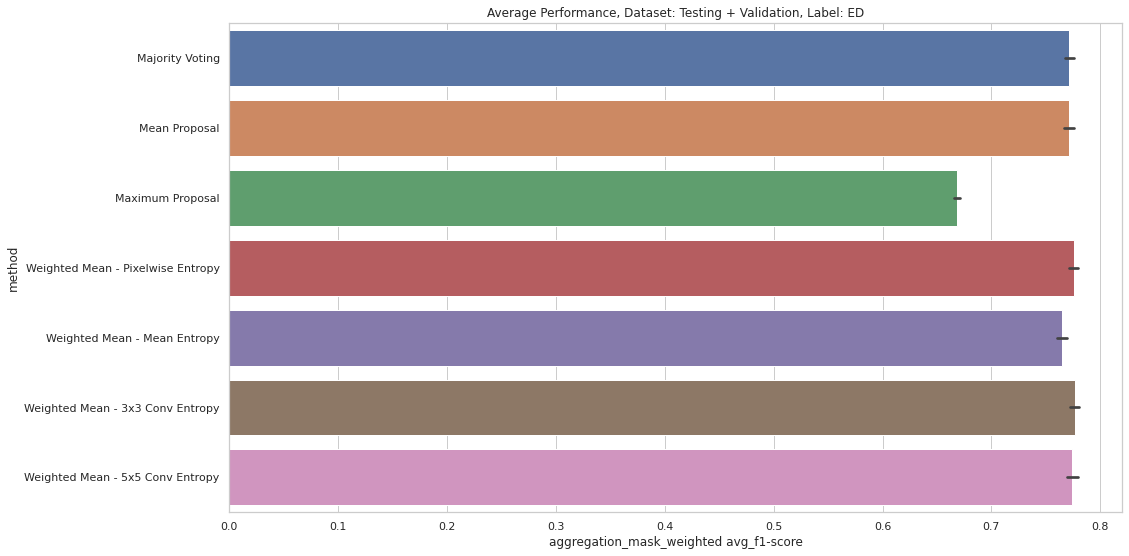

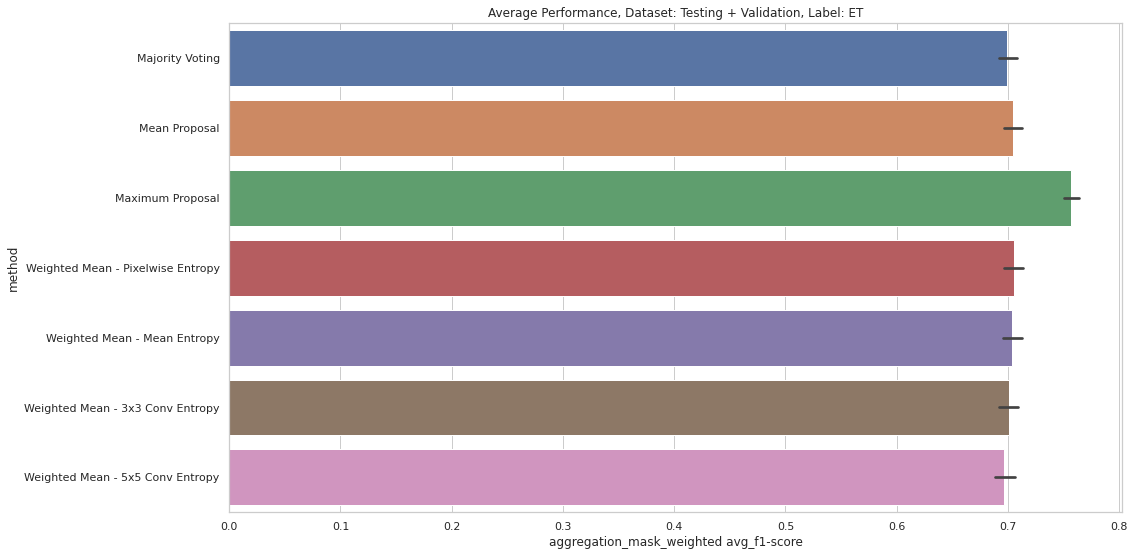

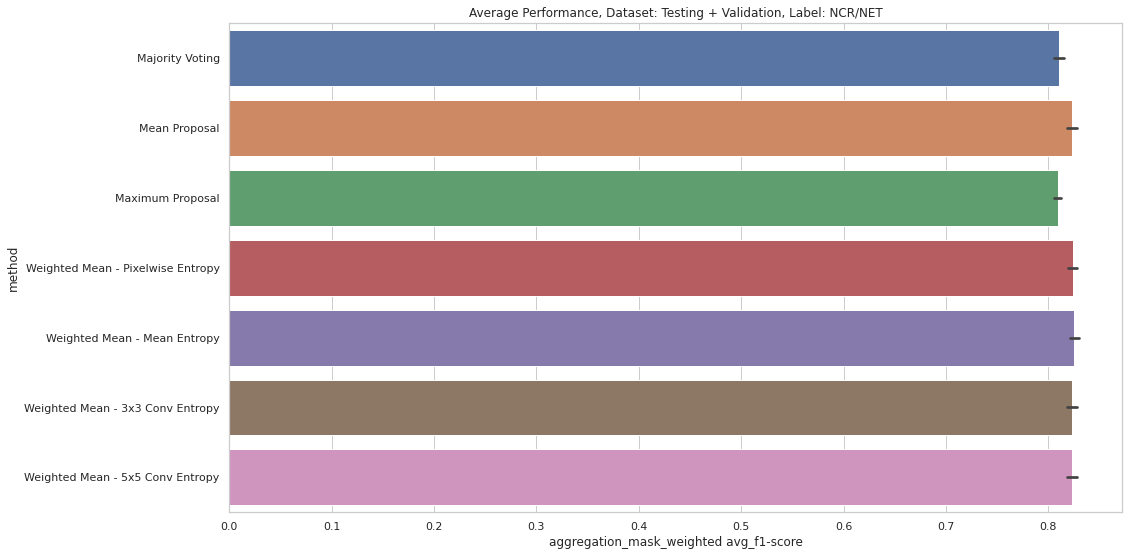

In [22]:
for label, data_label in data.groupby(['output_label']):
    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 9))
    sns.barplot(y='method', x='aggregation_mask_weighted avg_f1-score', data=data_label)
    plt.title('Average Performance, Dataset: Testing + Validation, Label: {}'.format(label))

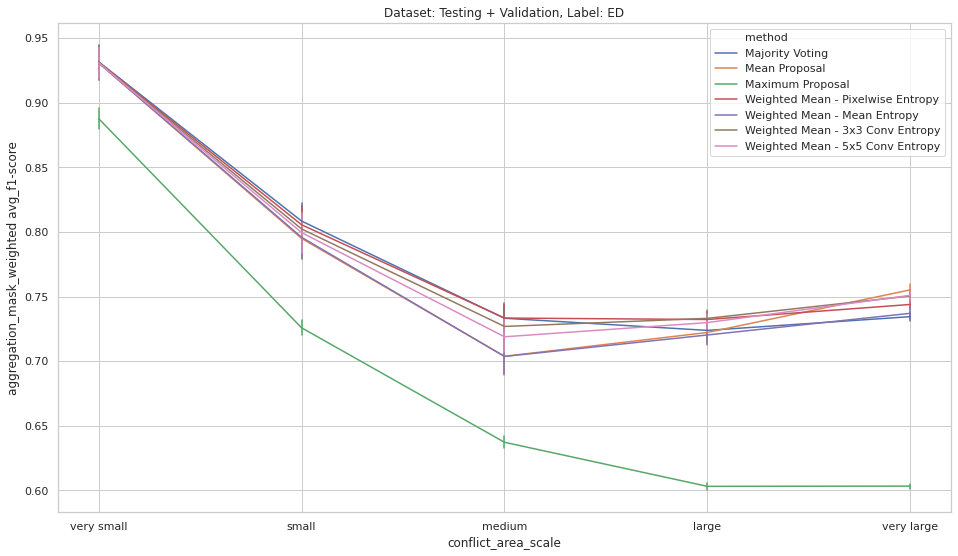

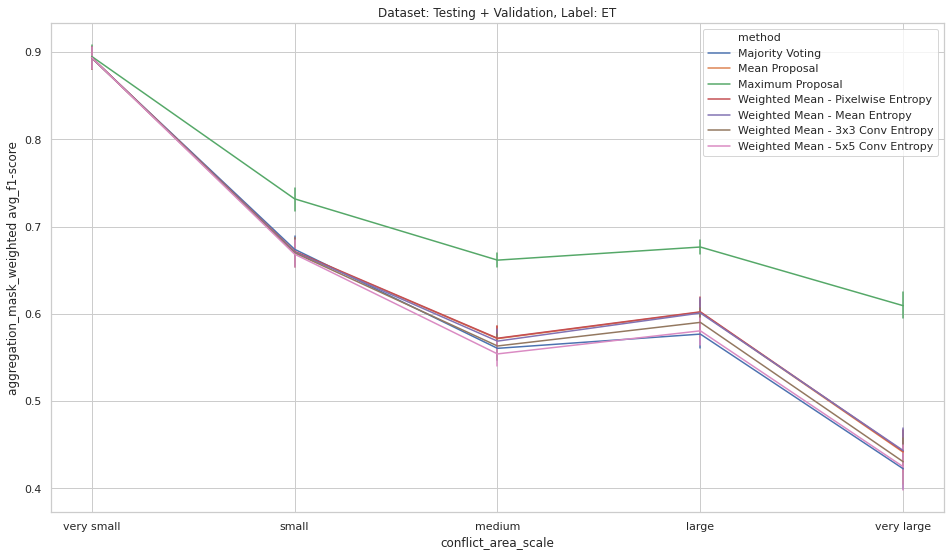

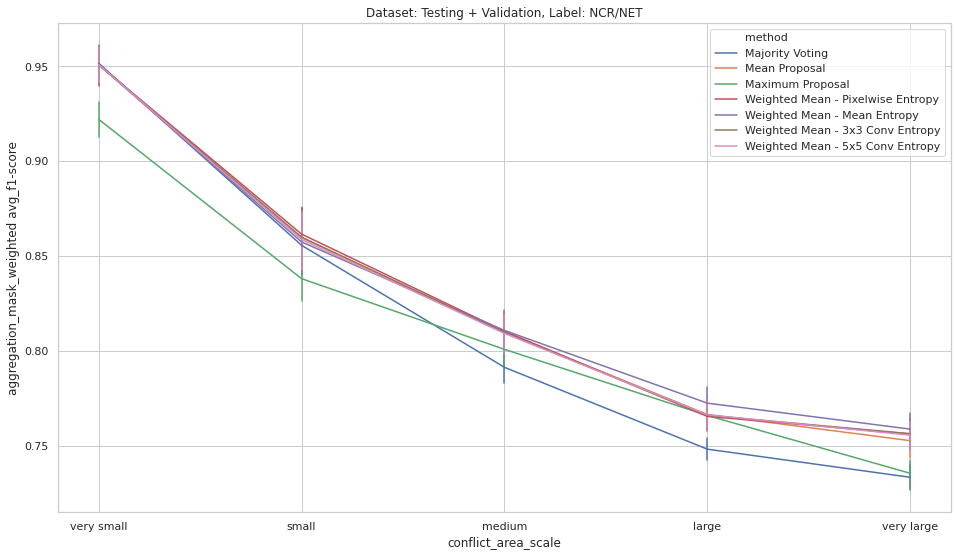

In [29]:
for label, data_label in data.groupby(['output_label']):
    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 9))
    sns.lineplot(hue='method', y='aggregation_mask_weighted avg_f1-score', x='conflict_area_scale', data=data_label, err_style='bars')
    plt.title('Dataset: Testing + Validation, Label: {}'.format(label))
    

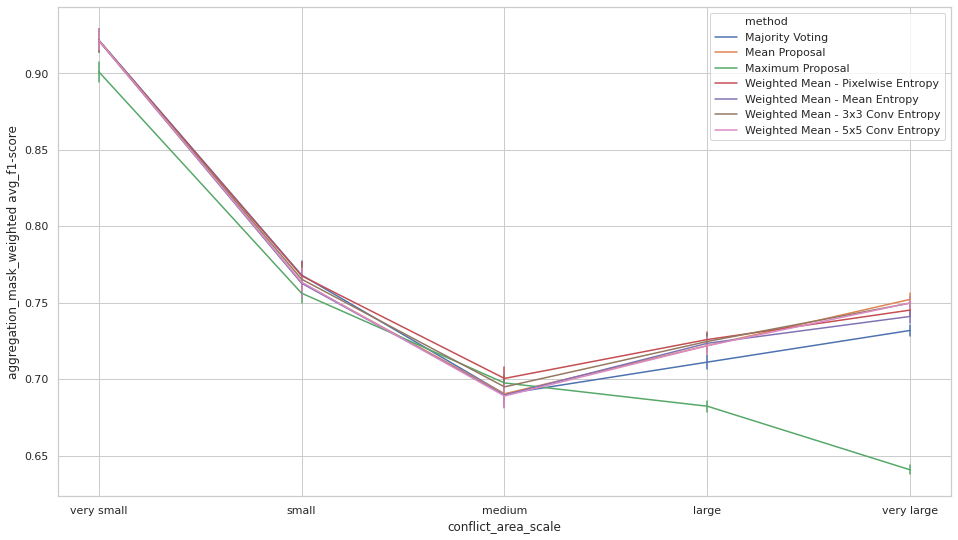

In [30]:
plt.figure(figsize=(16,9))
sns.lineplot(hue='method', y='aggregation_mask_weighted avg_f1-score', x='conflict_area_scale', data=data, err_style='bars')

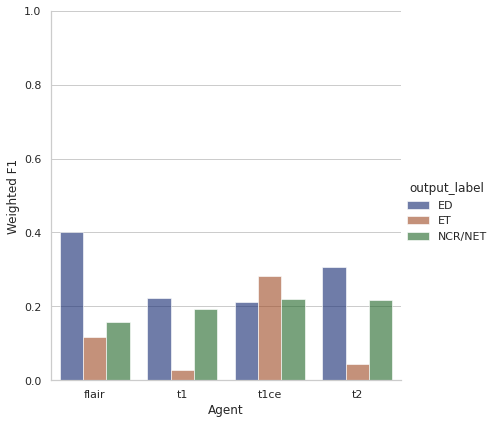

In [108]:
basecolumns = ['slice', 'output_label', 'patient']
agent_prefixes = ['t1', 't1ce', 't2', 'flair']
agent_columns = [f'{pref}_proposal_full_Positive_f1-score' for pref in agent_prefixes]
agent_perf = data.loc[data.method == 'Mean Proposal'][basecolumns + agent_columns]
agent_perf = agent_perf.melt(id_vars=basecolumns, var_name='Agent', value_name='Weighted F1')
agent_perf['Agent'] = agent_perf['Agent'].apply(lambda x: x.split('_')[0])
agent_perf

g = sns.catplot(
    data=agent_perf.groupby(['Agent', 'output_label']).mean().reset_index(), kind="bar",
    x="Agent", y="Weighted F1", hue="output_label",
    ci=None, palette="dark", alpha=.6, height=6
)
g.set(ylim=(0., 1.))

In [110]:
basecolumns = ['slice', 'output_label', 'patient']
agent_prefixes = ['t1', 't1ce', 't2', 'flair']
agent_columns = [f'{pref}_proposal_mask_Positive_f1-score' for pref in agent_prefixes]
agent_perf = data.loc[data.method == 'Mean Proposal'][basecolumns + agent_columns]
agent_perf = agent_perf.melt(id_vars=basecolumns, var_name='Agent', value_name='Positive F1 (On Mask)')
agent_perf['Agent'] = agent_perf['Agent'].apply(lambda x: x.split('_')[0])
agent_perf

g = sns.catplot(
    data=agent_perf.groupby(['Agent', 'output_label']).mean().reset_index(), kind="bar",
    x="Agent", y='Positive F1 (On Mask)', hue="output_label",
    ci=None, palette="dark", alpha=.6, height=6
)
g.set(ylim=(0., 1.))

ValueError: Could not interpret input 'Weighted F1'

In [ ]:
# TODO: Devo usare Weighted o Positive F1? Devo usare Mask o Full?
# TODO: Bisogna aggregare in qualche modo il count dei voti NvsM per poterlo visualizzare

Plot the heatmap showing the mean F1 score of each method when i agents voted for positive and (N-i) for negative label, with respect to the total area of the mask

In [276]:
basecolumns = ['slice', 'output_label', 'patient', 'method']
metric_col = ['aggregation_mask_Positive_f1-score']
votes_col = ['votes_Negative_vs_Positive_1vs3_norm', 'votes_Negative_vs_Positive_2vs2_norm', 'votes_Negative_vs_Positive_3vs1_norm']
metric_col_friendname = ['F1']
votes_col_friendname = ['1v3', '2v2', '3v1']
current_data = data[basecolumns + metric_col + votes_col]
current_data = current_data.rename(columns={old:new for old, new in zip(votes_col, votes_col_friendly_names)})
current_data = current_data.rename(columns={old:new for old, new in zip(metric_col, metric_col_friendname)})
current_data = current_data.melt(id_vars = basecolumns+metric_col_friendname, var_name='Vote Balance', value_name="VoteMaskPerc")
# Grouping the vote percentages
resolution = 1./(256*256)
current_data['Mask %'] = pd.cut(current_data['VoteMaskPerc'], bins=[0, resolution,  .25, .50, .75, 1.-resolution, 1], labels=['0%', '(0%-25%]', '(25%-50%]', '(50%-75%]', '(75%-100%)', '100%'], include_lowest=True, right=True)

In [277]:
current_data

,slice,output_label,patient,method,F1,Vote Balance,VoteMaskPerc,Mask %
0,9,ED,6290,Majority Voting,0.0,1v3,0.0,0%
1,9,ED,6290,Mean Proposal,0.0,1v3,0.0,0%
2,9,ED,6290,Maximum Proposal,0.0,1v3,0.0,0%
3,9,ED,6290,Weighted Mean - Pixelwise Entropy,0.0,1v3,0.0,0%
4,9,ED,6290,Weighted Mean - Mean Entropy,0.0,1v3,0.0,0%
...,...,...,...,...,...,...,...,...
465523,91,NCR/NET,BLJ,Maximum Proposal,0.0,3v1,1.0,100%
465524,91,NCR/NET,BLJ,Weighted Mean - Pixelwise Entropy,0.0,3v1,1.0,100%
465525,91,NCR/NET,BLJ,Weighted Mean - Mean Entropy,0.0,3v1,1.0,100%
465526,91,NCR/NET,BLJ,Weighted Mean - 3x3 Conv Entropy,0.0,3v1,1.0,100%


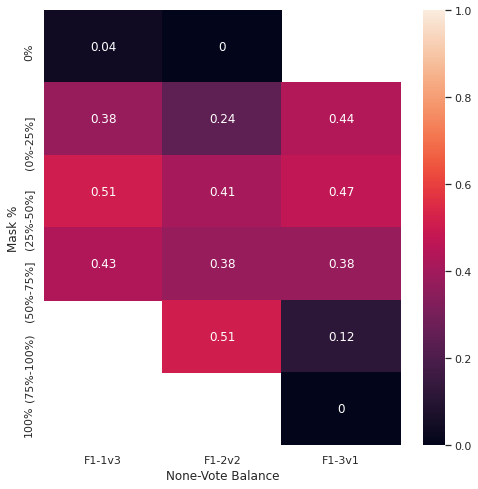

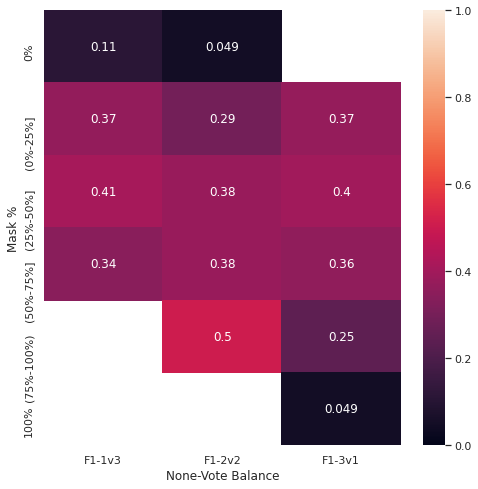

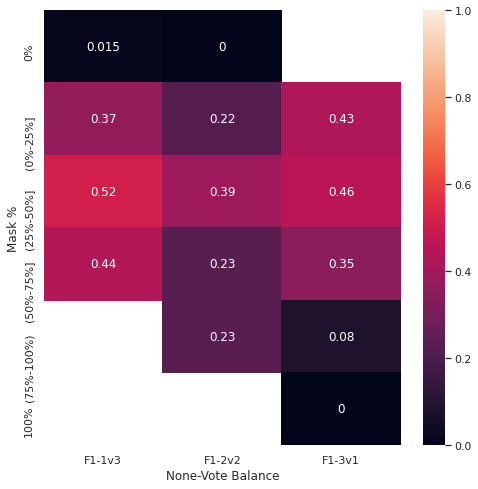

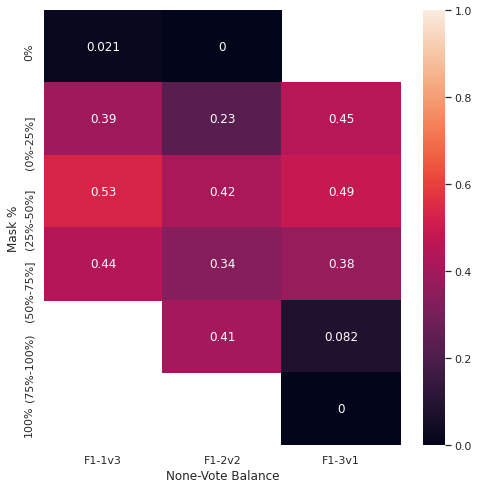

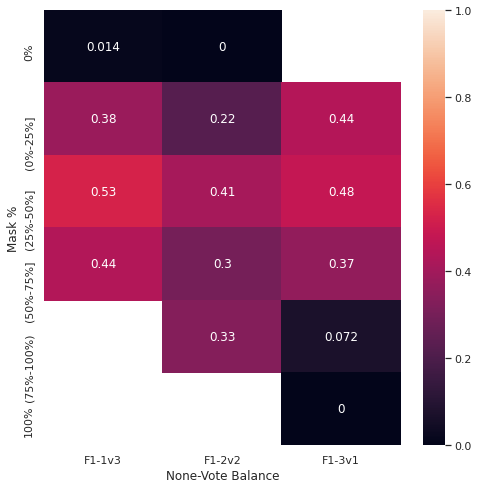

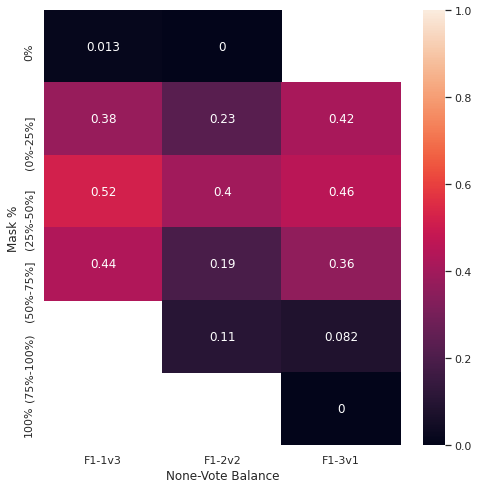

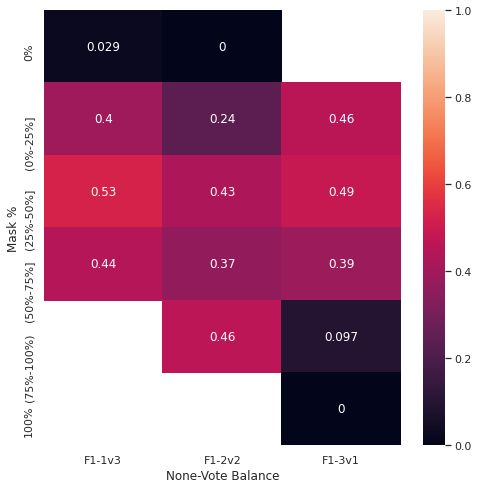

In [283]:
nmethods = len(current_data['method'].unique())

# Here we compute the mean for each case
performances_by_votebalance = current_data.groupby(['method', 'Mask %', 'Vote Balance']).mean().drop(columns=['slice', "VoteMaskPerc"])
# We need rectangular data for using sns.heatmap
for i, (meth, df) in enumerate(performances_by_votebalance.reset_index('Mask %').groupby(['method'])):
    plt.figure(figsize=(8, 8))
    rectangular_data = df.reset_index('Vote Balance').reset_index(drop=True).pivot('Mask %', 'Vote Balance', metric_col_friendname)
    sns.heatmap(rectangular_data, vmin=0., vmax=1., annot=True)
    

In [272]:
rectangular_data

aggregation_mask_Positive_f1-score                    
Vote Balance                                1v3       2v2       3v1
Mask %                                                             
0%                                     0.028872  0.000000       NaN
(0%-25%]                               0.396833  0.239343  0.459089
(25%-50%]                              0.529258  0.427254  0.490161
(50%-75%]                              0.442156  0.367178  0.388745
(75%-100%)                                  NaN  0.464096  0.096625
100%                                        NaN       NaN  0.000000

In [242]:
df

Mask %  \
method          Vote Balance                                       
Majority Voting votes_Negative_vs_Positive_1vs3_norm          0%   
                votes_Negative_vs_Positive_2vs2_norm          0%   
                votes_Negative_vs_Positive_3vs1_norm          0%   
                votes_Negative_vs_Positive_1vs3_norm    (0%-25%]   
                votes_Negative_vs_Positive_2vs2_norm    (0%-25%]   
                votes_Negative_vs_Positive_3vs1_norm    (0%-25%]   
                votes_Negative_vs_Positive_1vs3_norm   (25%-50%]   
                votes_Negative_vs_Positive_2vs2_norm   (25%-50%]   
                votes_Negative_vs_Positive_3vs1_norm   (25%-50%]   
                votes_Negative_vs_Positive_1vs3_norm   (50%-75%]   
                votes_Negative_vs_Positive_2vs2_norm   (50%-75%]   
                votes_Negative_vs_Positive_3vs1_norm   (50%-75%]   
                votes_Negative_vs_Positive_1vs3_norm  (75%-100%)   
                votes_Negative_vs_Positive_2vs2_norm  (75%-100%)   
                votes_Negative_vs_Positive_3vs1_norm  (75%-100%)   
                votes_Negative_vs_Positive_1vs3_norm        100%   
                votes_Negative_vs_Positive_2vs2_norm        100%   
                votes_Negative_vs_Positive_3vs1_norm        100%   

                                                      aggregation_mask_Positive_f1-score  
method          Vote Balance                                                              
Majority Voting votes_Negative_vs_Positive_1vs3_norm                            0.040257  
                votes_Negative_vs_Positive_2vs2_norm                            0.000000  
                votes_Negative_vs_Positive_3vs1_norm                                 NaN  
                votes_Negative_vs_Positive_1vs3_norm                            0.378057  
                votes_Negative_vs_Positive_2vs2_norm                            0.244490  
                votes_Negative_vs_Positive_3vs1_norm                            0.440760  
                votes_Negative_vs_Positive_1vs3_norm                            0.509480  
                votes_Negative_vs_Positive_2vs2_norm                            0.412341  
                votes_Negative_vs_Positive_3vs1_norm                            0.473405  
                votes_Negative_vs_Positive_1vs3_norm                            0.433268  
                votes_Negative_vs_Positive_2vs2_norm                            0.377994  
                votes_Negative_vs_Positive_3vs1_norm                            0.375578  
                votes_Negative_vs_Positive_1vs3_norm                                 NaN  
                votes_Negative_vs_Positive_2vs2_norm                            0.513398  
                votes_Negative_vs_Positive_3vs1_norm                            0.117263  
                votes_Negative_vs_Positive_1vs3_norm                                 NaN  
                votes_Negative_vs_Positive_2vs2_norm                                 NaN  
                votes_Negative_vs_Positive_3vs1_norm                            0.000000

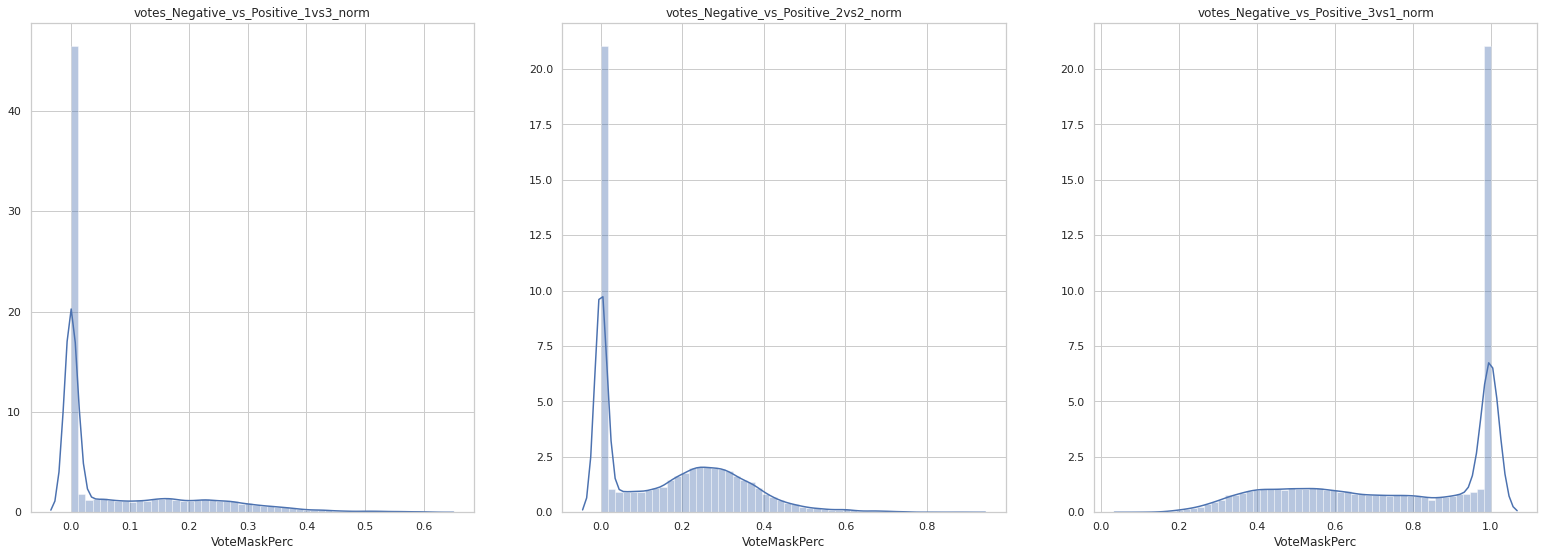

In [147]:
plt.figure(figsize=(27, 9))
for i, (votebal, cd) in enumerate(current_data.groupby(['Vote Balance'])):
    plt.subplot(1, 3, i+1)
    sns.distplot(cd['VoteMaskPerc'])
    plt.title(votebal)

In [127]:
for method, current_data in data.groupby(['method']):
    for votes_col in ['votes_Negative_vs_Positive_1vs3', 'votes_Negative_vs_Positive_2vs2', 'votes_Negative_vs_Positive_3vs1']:
        
    pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [126]:
current_data[f"{votes_col}_norm"].max()

9.857142857142858

In [121]:
current_data.conflict_area

12         61
19         67
26         17
33         77
40        124
         ... 
174405    601
174412    474
174419    360
174426    143
174440      3
Name: conflict_area, Length: 22168, dtype: int64